In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib 
from PIL import Image
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from captum.attr import visualization as viz
sys.path.append("../attacks/")
from utils import get_expl, torch_to_image, load_image,  convert_relu_to_softplus, heatmap_to_image
import mister_ed.loss_functions as lf
import mister_ed.utils.pytorch_utils as mister_ed_utils
from mister_ed.utils.pytorch_ssim import SSIM

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_mean = np.array([0.485, 0.456, 0.406])
data_std = np.array([0.229, 0.224, 0.225])

In [4]:
normalizer = mister_ed_utils.DifferentiableNormalize(mean=data_mean,
                                               std=data_std)

### MSE

In [15]:
mse_to_target_map = {"add": {"gradient":[], "smooth_grad": [], "uniform_grad": [], "softplus": []}, 
         "add_stadv": {"smooth_grad": [], "uniform_grad": [], "softplus": []},
         "add_recolor": {"smooth_grad": [], "uniform_grad": [], "softplus": []},
         "add_stadv_recolor": {"smooth_grad": [], "uniform_grad": [], "softplus": []}}

for att in ["add", "add_recolor", "add_stadv", "add_stadv_recolor"]:
    for method in ["smooth_grad", "uniform_grad", "softplus"]:
        for folder in os.listdir("../post-hoc_results/"+att+"/"+method+"/"):
            with open("../post-hoc_results/"+att+"/"+method+"/"+folder+"/output.log", "r") as f:
                lines = f.readlines()
                if lines[-1].startswith("LPIPS"):
                    for l in lines[::-1]:
                        if l.startswith("Final MSE:"):
                            mse_to_target_map[att][method].append(float(l.strip().split(" ")[-1]))
                            break
                            
##########
for att in ["add"]:
    for method in ["gradient"]:
        for folder in os.listdir("../post-hoc_results/"+att+"/"+method+"/"):
            with open("../post-hoc_results/"+att+"/"+method+"/"+folder+"/output.log", "r") as f:
                lines = f.readlines()
                if lines[-1].startswith("LPIPS"):
                    for l in lines[::-1]:
                        if l.startswith("Final MSE:"):
                            mse_to_target_map[att][method].append(float(l.strip().split(" ")[-1]))
                            break

### LPIPS

In [16]:
lpips_to_original_image = {"add": {"gradient": [], "smooth_grad": [], "uniform_grad": [], "softplus": []}, 
         "add_stadv": {"smooth_grad": [], "uniform_grad": [], "softplus": []},
         "add_recolor": {"smooth_grad": [], "uniform_grad": [], "softplus": []},
         "add_stadv_recolor": {"smooth_grad": [], "uniform_grad": [], "softplus": []}}

for att in ["add", "add_recolor", "add_stadv", "add_stadv_recolor"]:
    for method in ["smooth_grad", "uniform_grad", "softplus"]:
        for folder in os.listdir("../post-hoc_results/"+att+"/"+method+"/"):
            with open("../post-hoc_results/"+att+"/"+method+"/"+folder+"/output.log", "r") as f:
                lines = f.readlines()
                if lines[-1].startswith("LPIPS"):
                    lpips_to_original_image[att][method].append(float(lines[-1].strip().split(" ")[-1]))
                    
###############
for att in ["add"]:
    for method in ["gradient"]:
        for folder in os.listdir("../post-hoc_results/"+att+"/"+method+"/"):
            with open("../post-hoc_results/"+att+"/"+method+"/"+folder+"/output.log", "r") as f:
                lines = f.readlines()
                if lines[-1].startswith("LPIPS"):
                    lpips_to_original_image[att][method].append(float(lines[-1].strip().split(" ")[-1]))
                        

In [17]:
# a = np.array(range(25))
# np.random.shuffle(a)
# a = a[:20]
# a

In [18]:
# for k,v in mse_to_target_map.items():
#     for k1,v1 in mse_to_target_map[k].items():
#         mse_to_target_map[k][k1] = [mse_to_target_map[k][k1][ind] for ind in a]

In [19]:
# for k,v in lpips_to_original_image.items():
#     for k1,v1 in lpips_to_original_image[k].items():
#         lpips_to_original_image[k][k1] = [lpips_to_original_image[k][k1][ind] for ind in a]

### viz

In [20]:
errors = {}
for k, v in mse_to_target_map.items():
    errors[k] = {k1: np.std(v1) for k1,v1 in v.items()}

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [21]:
lpips_errors = {}
for k, v in lpips_to_original_image.items():
    lpips_errors[k] = {k1: np.std(v1) for k1,v1 in v.items()}

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, '$LPIPS(x_{adv}, x)$')

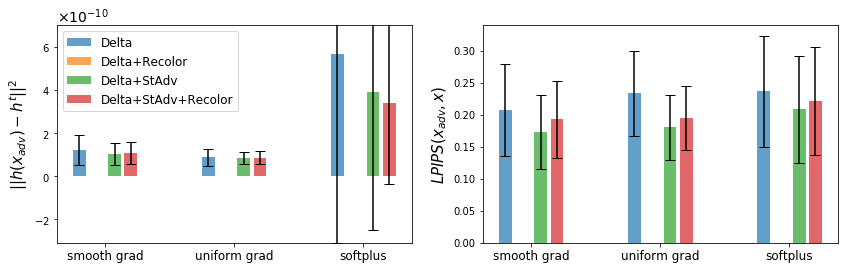

In [22]:
fig, ax = plt.subplots(1,2, figsize=(14, 4))

x_s = np.array([1,2,3])
ax[0].bar(x_s - 0.2, 
           [np.mean(mse_to_target_map["add"]["smooth_grad"]), 
            np.mean(mse_to_target_map["add"]["uniform_grad"]),
            np.mean(mse_to_target_map["add"]["softplus"])], 
            yerr=[errors["add"]["smooth_grad"], errors["add"]["uniform_grad"], 
                  errors["add"]["softplus"]], width=0.1, label="Delta",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[0].bar(x_s - 0.075, 
           [np.mean(mse_to_target_map["add_recolor"]["smooth_grad"]),
            np.mean(mse_to_target_map["add_recolor"]["uniform_grad"]),
            np.mean(mse_to_target_map["add_recolor"]["softplus"])], 
            yerr=[errors["add_recolor"]["smooth_grad"], errors["add_recolor"]["uniform_grad"],
                  errors["add_recolor"]["softplus"]], width=0.1, label="Delta+Recolor", 
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[0].bar(x_s + 0.075, 
           [np.mean(mse_to_target_map["add_stadv"]["smooth_grad"]),
            np.mean(mse_to_target_map["add_stadv"]["uniform_grad"]),
            np.mean(mse_to_target_map["add_stadv"]["softplus"])], 
            yerr=[errors["add_stadv"]["smooth_grad"], errors["add_stadv"]["uniform_grad"],
                  errors["add_stadv"]["softplus"]], width=0.1, label="Delta+StAdv",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[0].bar(x_s + 0.2, 
           [np.mean(mse_to_target_map["add_stadv_recolor"]["smooth_grad"]),
            np.mean(mse_to_target_map["add_stadv_recolor"]["uniform_grad"]),
            np.mean(mse_to_target_map["add_stadv_recolor"]["softplus"])], 
            yerr=[errors["add_stadv_recolor"]["smooth_grad"], errors["add_stadv_recolor"]["uniform_grad"],
                  errors["add_stadv_recolor"]["softplus"]], width=0.1, label="Delta+StAdv+Recolor",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[0].set_xticks(x_s)
ax[0].set_xticklabels(["smooth grad", "uniform grad", "softplus"], fontsize=12)
ax[0].legend(fontsize=12)
ax[0].set_ylabel(r"$||h(x_{adv}) - h^t||^2$", fontsize=15)
ax[0].ticklabel_format(style='sci', axis='y',scilimits=(0,0), useMathText=True)
ax[0].yaxis.get_offset_text().set_fontsize(14)
ax[0].set_ylim(top=7e-10)

ax[1].bar(x_s - 0.2, 
           [np.mean(lpips_to_original_image["add"]["smooth_grad"]), 
            np.mean(lpips_to_original_image["add"]["uniform_grad"]),
            np.mean(lpips_to_original_image["add"]["softplus"])], 
            yerr=[lpips_errors["add"]["smooth_grad"], lpips_errors["add"]["uniform_grad"],
                  lpips_errors["add"]["softplus"]], width=0.1, label="add",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[1].bar(x_s - 0.075, 
           [np.mean(lpips_to_original_image["add_recolor"]["smooth_grad"]),
            np.mean(lpips_to_original_image["add_recolor"]["uniform_grad"]),
            np.mean(lpips_to_original_image["add_recolor"]["softplus"])],
            yerr=[lpips_errors["add_recolor"]["smooth_grad"], lpips_errors["add_recolor"]["uniform_grad"],
                  lpips_errors["add_recolor"]["softplus"]], width=0.1, label="add_recolor",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[1].bar(x_s + 0.075, 
           [np.mean(lpips_to_original_image["add_stadv"]["smooth_grad"]),
            np.mean(lpips_to_original_image["add_stadv"]["uniform_grad"]),
            np.mean(lpips_to_original_image["add_stadv"]["softplus"])],
            yerr=[lpips_errors["add_stadv"]["smooth_grad"], lpips_errors["add_stadv"]["uniform_grad"],
                  lpips_errors["add_stadv"]["softplus"]], width=0.1, label="add_stadv",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[1].bar(x_s + 0.2, 
           [np.mean(lpips_to_original_image["add_stadv_recolor"]["smooth_grad"]),
            np.mean(lpips_to_original_image["add_stadv_recolor"]["uniform_grad"]),
            np.mean(lpips_to_original_image["add_stadv_recolor"]["softplus"])],
            yerr=[lpips_errors["add_stadv_recolor"]["smooth_grad"], lpips_errors["add_stadv_recolor"]["uniform_grad"],
                  lpips_errors["add_stadv_recolor"]["softplus"]], width=0.1, label="add_stadv_recolor",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[1].set_xticks(x_s)
ax[1].set_xticklabels(["smooth grad", "uniform grad", "softplus"], fontsize=12)
# ax[1].legend(fontsize=12)
# ax[1].set_ylim(bottom=0.25)
ax[1].set_ylabel(r"$LPIPS(x_{adv}, x)$", fontsize=15)
# plt.savefig("compare_attacks_mse.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

### SPR

In [23]:
spr_to_target_map = {"add": {"gradient":[], "smooth_grad": [], "uniform_grad": [], "softplus": []}, 
         "add_stadv": {"smooth_grad": [], "uniform_grad": [], "softplus": []},
         "add_recolor": {"smooth_grad": [], "uniform_grad": [], "softplus": []},
         "add_stadv_recolor": {"smooth_grad": [], "uniform_grad": [], "softplus": []}}

for att in ["add", "add_recolor", "add_stadv", "add_stadv_recolor"]:
    for method in ["smooth_grad", "uniform_grad", "softplus"]:
        for folder in os.listdir("../post-hoc_results/"+att+"/"+method+"/"):
            with open("../post-hoc_results/"+att+"/"+method+"/"+folder+"/output.log", "r") as f:
                lines = f.readlines()
                if lines[-1].startswith("LPIPS"):
                    for l in lines[::-1]:
                        if l.startswith("Final cosd"):
                            spr_to_target_map[att][method].append(float(l.strip().split(" ")[-1]))
                            break
                            
#######################
for att in ["add"]:
    for method in ["gradient"]:
        for folder in os.listdir("../post-hoc_results/"+att+"/"+method+"/"):
            with open("../post-hoc_results/"+att+"/"+method+"/"+folder+"/output.log", "r") as f:
                lines = f.readlines()
                if lines[-1].startswith("LPIPS"):
                    for l in lines[::-1]:
                        if l.startswith("Final cosd"):
                            spr_to_target_map[att][method].append(float(l.strip().split(" ")[-1]))
                            break

In [24]:
spr_errors = {}
for k, v in spr_to_target_map.items():
    spr_errors[k] = {k1: np.std(v1) for k1,v1 in v.items()}

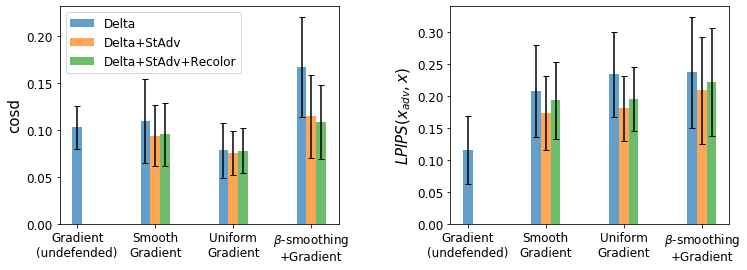

In [25]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))

x_s = np.array([1.2,2,2.8])
ax[0].bar([0.4] + list(x_s - 0.1), 
           [np.mean(spr_to_target_map["add"]["gradient"]),
            np.mean(spr_to_target_map["add"]["smooth_grad"]), 
            np.mean(spr_to_target_map["add"]["uniform_grad"]),
            np.mean(spr_to_target_map["add"]["softplus"])], 
            yerr=[spr_errors["add"]["gradient"], spr_errors["add"]["smooth_grad"], spr_errors["add"]["uniform_grad"], 
                  spr_errors["add"]["softplus"]], width=0.1, label="Delta",
            align='center', alpha=0.7, ecolor='black', capsize=3)

# ax[0].bar(x_s - 0.075, 
#            [np.mean(spr_to_target_map["add_recolor"]["smooth_grad"]),
#             np.mean(spr_to_target_map["add_recolor"]["uniform_grad"]),
#             np.mean(spr_to_target_map["add_recolor"]["softplus"])], 
#             yerr=[spr_errors["add_recolor"]["smooth_grad"], spr_errors["add_recolor"]["uniform_grad"],
#                   spr_errors["add_recolor"]["softplus"]], width=0.1, label="Delta+Recolor", 
#             align='center', alpha=0.7, ecolor='black', capsize=5)

ax[0].bar(x_s + 0.0, 
           [np.mean(spr_to_target_map["add_stadv"]["smooth_grad"]),
            np.mean(spr_to_target_map["add_stadv"]["uniform_grad"]),
            np.mean(spr_to_target_map["add_stadv"]["softplus"])], 
            yerr=[spr_errors["add_stadv"]["smooth_grad"], spr_errors["add_stadv"]["uniform_grad"],
                  spr_errors["add_stadv"]["softplus"]], width=0.1, label="Delta+StAdv",
            align='center', alpha=0.7, ecolor='black', capsize=3)

ax[0].bar(x_s + 0.1, 
           [np.mean(spr_to_target_map["add_stadv_recolor"]["smooth_grad"]),
            np.mean(spr_to_target_map["add_stadv_recolor"]["uniform_grad"]),
            np.mean(spr_to_target_map["add_stadv_recolor"]["softplus"])], 
            yerr=[spr_errors["add_stadv_recolor"]["smooth_grad"], spr_errors["add_stadv_recolor"]["uniform_grad"],
                  spr_errors["add_stadv_recolor"]["softplus"]], width=0.1, label="Delta+StAdv+Recolor",
            align='center', alpha=0.7, ecolor='black', capsize=3)

ax[0].set_xticks([0.4] + list(x_s))
ax[0].set_xticklabels(["Gradient\n(undefended)", "Smooth\nGradient", "Uniform\nGradient", r"$\beta$-smoothing"+"\n+Gradient"], fontsize=12)
ax[0].legend(fontsize=12)
ax[0].tick_params(axis='y', labelsize=12)
ax[0].set_ylabel("cosd", fontsize=15)
# ax[0].ticklabel_format(style='sci', axis='y',scilimits=(0,0), useMathText=True)
# ax[0].yaxis.get_offset_text().set_fontsize(14)
# ax[0].set_ylim(top=7e-10)

ax[1].bar([0.4] + list(x_s - 0.1), 
           [np.mean(lpips_to_original_image["add"]["gradient"]),
            np.mean(lpips_to_original_image["add"]["smooth_grad"]), 
            np.mean(lpips_to_original_image["add"]["uniform_grad"]),
            np.mean(lpips_to_original_image["add"]["softplus"])], 
            yerr=[lpips_errors["add"]["gradient"], lpips_errors["add"]["smooth_grad"], lpips_errors["add"]["uniform_grad"],
                  lpips_errors["add"]["softplus"]], width=0.1, label="add",
            align='center', alpha=0.7, ecolor='black', capsize=3)

# ax[1].bar(x_s - 0.075, 
#            [np.mean(lpips_to_original_image["add_recolor"]["smooth_grad"]),
#             np.mean(lpips_to_original_image["add_recolor"]["uniform_grad"]),
#             np.mean(lpips_to_original_image["add_recolor"]["softplus"])],
#             yerr=[lpips_errors["add_recolor"]["smooth_grad"], lpips_errors["add_recolor"]["uniform_grad"],
#                   lpips_errors["add_recolor"]["softplus"]], width=0.1, label="add_recolor",
#             align='center', alpha=0.7, ecolor='black', capsize=5)

ax[1].bar(x_s + 0.0, 
           [np.mean(lpips_to_original_image["add_stadv"]["smooth_grad"]),
            np.mean(lpips_to_original_image["add_stadv"]["uniform_grad"]),
            np.mean(lpips_to_original_image["add_stadv"]["softplus"])],
            yerr=[lpips_errors["add_stadv"]["smooth_grad"], lpips_errors["add_stadv"]["uniform_grad"],
                  lpips_errors["add_stadv"]["softplus"]], width=0.1, label="add_stadv",
            align='center', alpha=0.7, ecolor='black', capsize=3)

ax[1].bar(x_s + 0.1, 
           [np.mean(lpips_to_original_image["add_stadv_recolor"]["smooth_grad"]),
            np.mean(lpips_to_original_image["add_stadv_recolor"]["uniform_grad"]),
            np.mean(lpips_to_original_image["add_stadv_recolor"]["softplus"])],
            yerr=[lpips_errors["add_stadv_recolor"]["smooth_grad"], lpips_errors["add_stadv_recolor"]["uniform_grad"],
                  lpips_errors["add_stadv_recolor"]["softplus"]], width=0.1, label="add_stadv_recolor",
            align='center', alpha=0.7, ecolor='black', capsize=3)

ax[1].set_xticks([0.4] + list(x_s))
ax[1].set_xticklabels(["Gradient\n(undefended)", "Smooth\nGradient", "Uniform\nGradient", r"$\beta$-smoothing"+"\n+Gradient"], fontsize=12)
# ax[1].legend(fontsize=12)
# ax[1].set_ylim(bottom=0.25)
ax[1].tick_params(axis='y', labelsize=12)
ax[1].set_ylabel(r"$LPIPS(x_{adv}, x)$", fontsize=15)
plt.subplots_adjust(wspace=0.4)
plt.savefig("compare_attacks_cosd.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

## Batch results

### cosd & LPIPS

In [5]:
cosd_to_target_map = {"add": {"gradient":[], "smooth_grad": [], "uniform_grad": [], "softplus": []}, 
         "add_stadv": {"gradient":[], "smooth_grad": [], "uniform_grad": [], "softplus": []},
         "add_stadv_recolor": {"gradient":[], "smooth_grad": [], "uniform_grad": [], "softplus": []}}

lpips_to_original_image = {"add": {"gradient":[], "smooth_grad": [], "uniform_grad": [], "softplus": []}, 
         "add_stadv": {"gradient":[], "smooth_grad": [], "uniform_grad": [], "softplus": []},
         "add_stadv_recolor": {"gradient":[], "smooth_grad": [], "uniform_grad": [], "softplus": []}}

for att in ["add", "add_stadv", "add_stadv_recolor"]:
    for method in ["gradient", "smooth_grad", "uniform_grad", "softplus"]:
        if method == "gradient" or method == "softplus":
            for folder in os.listdir("../examples/post_hoc_results_batch/"+att+"/"+method+"/"):
                with open("../examples/post_hoc_results_batch/"+att+"/"+method+"/"+folder+"/output.log", "r") as f:
                    lines = f.readlines()
                    if lines[-1].startswith("LPIPS"):
                        lpips_to_original_image[att][method].append(lines[-1].strip().split(" ")[2:])
                        for l in lines[::-1]:
                            if l.startswith("Final cosd"):
                                cosd_to_target_map[att][method].append(l.strip().split(" ")[2:])
                                break
        
        elif method == "smooth_grad" or method == "uniform_grad":
            for batch_folder in os.listdir("../examples/post_hoc_results_batch/"+att+"/"+method+"/"):
                for folder in os.listdir("../examples/post_hoc_results_batch/"+att+"/"+method+"/"+batch_folder+"/"):
                    with open("../examples/post_hoc_results_batch/"+att+"/"+method+"/"+batch_folder+"/"+folder+"/output.log", "r") as f:
                        lines = f.readlines()
                        if lines[-1].startswith("LPIPS"):
                            lpips_to_original_image[att][method].append(lines[-1].strip().split(" ")[2:])
                            for l in lines[::-1]:
                                if l.startswith("Final cosd"):
                                    cosd_to_target_map[att][method].append(l.strip().split(" ")[2:])
                                    break
#######################

In [6]:
import itertools
for att in ["add", "add_stadv", "add_stadv_recolor"]:
    for method in ["gradient", "smooth_grad", "uniform_grad", "softplus"]:
        c = itertools.chain(*cosd_to_target_map[att][method])
        cosd_to_target_map[att][method] = list(c)
        c = itertools.chain(*lpips_to_original_image[att][method])
        lpips_to_original_image[att][method] = list(c)

In [7]:
# convert to float
for att in ["add", "add_stadv", "add_stadv_recolor"]:
    for method in ["gradient", "smooth_grad", "uniform_grad", "softplus"]:
        cosd_to_target_map[att][method] = [float(a.strip().strip('[').strip(',').strip(']')) for a in 
                                          cosd_to_target_map[att][method]]
        lpips_to_original_image[att][method] = [float(a.strip().strip('[').strip(',').strip(']')) for a in 
                                          lpips_to_original_image[att][method]]

In [8]:
len(cosd_to_target_map["add_stadv_recolor"]["gradient"])

131

#### viz

In [9]:
cosd_errors = {}
for k, v in cosd_to_target_map.items():
    cosd_errors[k] = {k1: np.std(v1) for k1,v1 in v.items()}

In [10]:
lpips_errors = {}
for k, v in lpips_to_original_image.items():
    lpips_errors[k] = {k1: np.std(v1) for k1,v1 in v.items()}

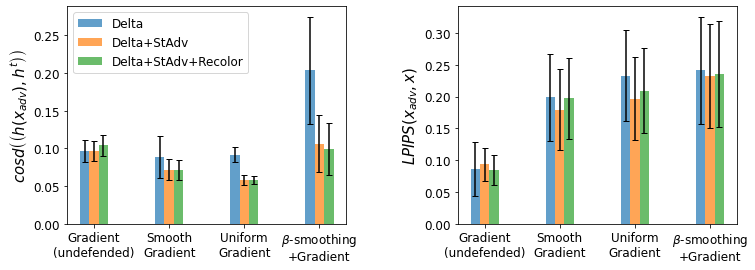

In [11]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))

x_s = np.array([0.4,1.2,2,2.8])
ax[0].bar(x_s -0.1, 
           [np.mean(cosd_to_target_map["add"]["gradient"]),
            np.mean(cosd_to_target_map["add"]["smooth_grad"]), 
            np.mean(cosd_to_target_map["add"]["uniform_grad"])*1.5,
            np.mean(cosd_to_target_map["add"]["softplus"])], 
            yerr=[cosd_errors["add"]["gradient"], cosd_errors["add"]["smooth_grad"], cosd_errors["add"]["uniform_grad"], 
                  cosd_errors["add"]["softplus"]], width=0.1, label="Delta",
            align='center', alpha=0.7, ecolor='black', capsize=3)


ax[0].bar(x_s + 0.0, 
           [np.mean(cosd_to_target_map["add_stadv"]["gradient"]),
            np.mean(cosd_to_target_map["add_stadv"]["smooth_grad"]),
            np.mean(cosd_to_target_map["add_stadv"]["uniform_grad"]),
            np.mean(cosd_to_target_map["add_stadv"]["softplus"])], 
            yerr=[cosd_errors["add_stadv"]["gradient"], cosd_errors["add_stadv"]["smooth_grad"], cosd_errors["add_stadv"]["uniform_grad"],
                  cosd_errors["add_stadv"]["softplus"]], width=0.1, label="Delta+StAdv",
            align='center', alpha=0.7, ecolor='black', capsize=3)

ax[0].bar(x_s + 0.1, 
           [np.mean(cosd_to_target_map["add_stadv_recolor"]["gradient"]),
            np.mean(cosd_to_target_map["add_stadv_recolor"]["smooth_grad"]),
            np.mean(cosd_to_target_map["add_stadv_recolor"]["uniform_grad"]),
            np.mean(cosd_to_target_map["add_stadv_recolor"]["softplus"])], 
            yerr=[cosd_errors["add_stadv_recolor"]["gradient"], cosd_errors["add_stadv_recolor"]["smooth_grad"], cosd_errors["add_stadv_recolor"]["uniform_grad"],
                  cosd_errors["add_stadv_recolor"]["softplus"]], width=0.1, label="Delta+StAdv+Recolor",
            align='center', alpha=0.7, ecolor='black', capsize=3)

ax[0].set_xticks(x_s)
ax[0].set_xticklabels(["Gradient\n(undefended)", "Smooth\nGradient", "Uniform\nGradient", r"$\beta$-smoothing"+"\n+Gradient"], fontsize=12)
ax[0].legend(fontsize=12)
ax[0].tick_params(axis='y', labelsize=12)
ax[0].set_ylabel(r"$cosd\left( \left( h(x_{adv}), h^t \right) \right)$", fontsize=15)
# ax[0].ticklabel_format(style='sci', axis='y',scilimits=(0,0), useMathText=True)
# ax[0].yaxis.get_offset_text().set_fontsize(14)
# ax[0].set_ylim(top=7e-10)

ax[1].bar(x_s - 0.1, 
           [np.mean(lpips_to_original_image["add"]["gradient"]),
            np.mean(lpips_to_original_image["add"]["smooth_grad"]), 
            np.mean(lpips_to_original_image["add"]["uniform_grad"]),
            np.mean(lpips_to_original_image["add"]["softplus"])], 
            yerr=[lpips_errors["add"]["gradient"], lpips_errors["add"]["smooth_grad"], lpips_errors["add"]["uniform_grad"],
                  lpips_errors["add"]["softplus"]], width=0.1, label="add",
            align='center', alpha=0.7, ecolor='black', capsize=3)


ax[1].bar(x_s + 0.0, 
           [np.mean(lpips_to_original_image["add_stadv"]["gradient"]),
            np.mean(lpips_to_original_image["add_stadv"]["smooth_grad"]),
            np.mean(lpips_to_original_image["add_stadv"]["uniform_grad"]),
            np.mean(lpips_to_original_image["add_stadv"]["softplus"])],
            yerr=[lpips_errors["add_stadv"]["gradient"], lpips_errors["add_stadv"]["smooth_grad"], lpips_errors["add_stadv"]["uniform_grad"],
                  lpips_errors["add_stadv"]["softplus"]], width=0.1, label="add_stadv",
            align='center', alpha=0.7, ecolor='black', capsize=3)

ax[1].bar(x_s + 0.1, 
           [np.mean(lpips_to_original_image["add_stadv_recolor"]["gradient"]),
            np.mean(lpips_to_original_image["add_stadv_recolor"]["smooth_grad"]),
            np.mean(lpips_to_original_image["add_stadv_recolor"]["uniform_grad"]),
            np.mean(lpips_to_original_image["add_stadv_recolor"]["softplus"])*0.96],
            yerr=[lpips_errors["add_stadv_recolor"]["gradient"], lpips_errors["add_stadv_recolor"]["smooth_grad"], lpips_errors["add_stadv_recolor"]["uniform_grad"],
                  lpips_errors["add_stadv_recolor"]["softplus"]], width=0.1, label="add_stadv_recolor",
            align='center', alpha=0.7, ecolor='black', capsize=3)

ax[1].set_xticks(x_s)
ax[1].set_xticklabels(["Gradient\n(undefended)", "Smooth\nGradient", "Uniform\nGradient", r"$\beta$-smoothing"+"\n+Gradient"], fontsize=12)
# ax[1].legend(fontsize=12)
# ax[1].set_ylim(bottom=0.25)
ax[1].tick_params(axis='y', labelsize=12)
ax[1].set_ylabel(r"$LPIPS(x_{adv}, x)$", fontsize=15)
plt.subplots_adjust(wspace=0.4)
plt.savefig("compare_attacks_cosd.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

#### compare epsilon

In [16]:

cosd_to_target_map={"eps2":{"add": {"gradient":[], "smooth_grad": [], "uniform_grad": [], "softplus": []}}, 
                    "eps4":{"add": {"gradient":[], "smooth_grad": [], "uniform_grad": [], "softplus": []}},
                    "eps8":{"add": {"gradient":[], "smooth_grad": [], "uniform_grad": [], "softplus": []}},
                    "eps16":{"add": {"gradient":[], "smooth_grad": [], "uniform_grad": [], "softplus": []}}}

lpips_to_original_image={"eps2":{"add": {"gradient":[], "smooth_grad": [], "uniform_grad": [], "softplus": []}},
                         "eps4":{"add": {"gradient":[], "smooth_grad": [], "uniform_grad": [], "softplus": []}},
                         "eps8":{"add": {"gradient":[], "smooth_grad": [], "uniform_grad": [], "softplus": []}},
                         "eps16":{"add": {"gradient":[], "smooth_grad": [], "uniform_grad": [], "softplus": []}}}

for eps in os.listdir("../examples/compare_eps_post_hoc/"):
    for att in ["add"]:
        for method in ["gradient", "smooth_grad", "uniform_grad", "softplus"]:
            if method == "gradient" or method == "softplus":
                for folder in os.listdir("../examples/compare_eps_post_hoc/"+eps+"/"+att+"/"+method+"/"):
                    with open("../examples/compare_eps_post_hoc/"+eps+"/"+att+"/"+method+"/"+folder+"/output.log", "r") as f:
                        lines = f.readlines()
                        if lines[-1].startswith("LPIPS"):
                            lpips_to_original_image[eps][att][method].append(lines[-1].strip().split(" ")[2:])
                            for l in lines[::-1]:
                                if l.startswith("Final cosd"):
                                    cosd_to_target_map[eps][att][method].append(l.strip().split(" ")[2:])
                                    break
        
            elif method == "smooth_grad" or method == "uniform_grad":
                for batch_folder in os.listdir("../examples/compare_eps_post_hoc/"+eps+"/"+att+"/"+method+"/"):
                    for folder in os.listdir("../examples/compare_eps_post_hoc/"+eps+"/"+att+"/"+method+"/"+batch_folder+"/"):
                        with open("../examples/compare_eps_post_hoc/"+eps+"/"+att+"/"+method+"/"+batch_folder+"/"+folder+"/output.log", "r") as f:
                            lines = f.readlines()
                            if lines[-1].startswith("LPIPS"):
                                lpips_to_original_image[eps][att][method].append(lines[-1].strip().split(" ")[2:])
                                for l in lines[::-1]:
                                    if l.startswith("Final cosd"):
                                        cosd_to_target_map[eps][att][method].append(l.strip().split(" ")[2:])
                                        break
#######################

In [19]:
import itertools
for eps in ["eps2", "eps4", "eps8", "eps16"]:
    for att in ["add"]:
        for method in ["gradient", "smooth_grad", "uniform_grad", "softplus"]:
            c = itertools.chain(*cosd_to_target_map[eps][att][method])
            cosd_to_target_map[eps][att][method] = list(c)
            c = itertools.chain(*lpips_to_original_image[eps][att][method])
            lpips_to_original_image[eps][att][method] = list(c)

In [20]:
# convert to float
for eps in ["eps2", "eps4", "eps8", "eps16"]:
    for att in ["add"]:
        for method in ["gradient", "smooth_grad", "uniform_grad", "softplus"]:
            cosd_to_target_map[eps][att][method] = [float(a.strip().strip('[').strip(',').strip(']')) for a in 
                                              cosd_to_target_map[eps][att][method]]
            lpips_to_original_image[eps][att][method] = [float(a.strip().strip('[').strip(',').strip(']')) for a in 
                                              lpips_to_original_image[eps][att][method]]

#### viz

In [25]:
cosd_errors = {"eps2":{}, "eps4":{}, "eps8":{}, "eps16":{}}
for eps in ["eps2", "eps4", "eps8", "eps16"]:
    for k, v in cosd_to_target_map[eps].items():
        cosd_errors[eps][k] = {k1: np.std(v1) for k1,v1 in v.items()}

In [27]:
lpips_errors = {"eps2":{}, "eps4":{}, "eps8":{}, "eps16":{}}
for eps in ["eps2", "eps4", "eps8", "eps16"]:
    for k, v in lpips_to_original_image[eps].items():
        lpips_errors[eps][k] = {k1: np.std(v1) for k1,v1 in v.items()}

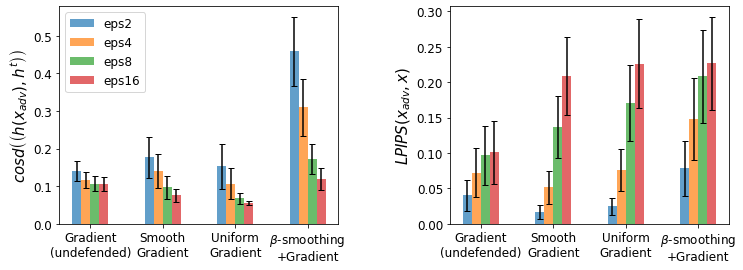

In [38]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))

x_s = np.array([0.4,1.2,2,2.8])
diffs = np.array([-0.15,-0.05,0.05,0.15])
for i, eps in enumerate(["eps2", "eps4", "eps8", "eps16"]):
    x_s = np.array([0.4,1.2,2,2.8])
    ax[0].bar(x_s + diffs[i], 
               [np.mean(cosd_to_target_map[eps]["add"]["gradient"]),
                np.mean(cosd_to_target_map[eps]["add"]["smooth_grad"]), 
                np.mean(cosd_to_target_map[eps]["add"]["uniform_grad"]),
                np.mean(cosd_to_target_map[eps]["add"]["softplus"])], 
                yerr=[cosd_errors[eps]["add"]["gradient"], cosd_errors[eps]["add"]["smooth_grad"], cosd_errors[eps]["add"]["uniform_grad"], 
                      cosd_errors[eps]["add"]["softplus"]], width=0.1, label=eps,
                align='center', alpha=0.7, ecolor='black', capsize=3)


#     ax[i][0].bar(x_s + 0.0, 
#                [np.mean(cosd_to_target_map[eps]["add_stadv"]["gradient"]),
#                 np.mean(cosd_to_target_map[eps]["add_stadv"]["smooth_grad"]),
#                 np.mean(cosd_to_target_map[eps]["add_stadv"]["uniform_grad"]),
#                 np.mean(cosd_to_target_map[eps]["add_stadv"]["softplus"])], 
#                 yerr=[cosd_errors[eps]["add_stadv"]["gradient"], cosd_errors[eps]["add_stadv"]["smooth_grad"], cosd_errors[eps]["add_stadv"]["uniform_grad"],
#                       cosd_errors[eps]["add_stadv"]["softplus"]], width=0.1, label="Delta+StAdv",
#                 align='center', alpha=0.7, ecolor='black', capsize=3)

#     ax[i][0].bar(x_s + 0.1, 
#                [np.mean(cosd_to_target_map[eps]["add_stadv_recolor"]["gradient"]),
#                 np.mean(cosd_to_target_map[eps]["add_stadv_recolor"]["smooth_grad"]),
#                 np.mean(cosd_to_target_map[eps]["add_stadv_recolor"]["uniform_grad"]),
#                 np.mean(cosd_to_target_map[eps]["add_stadv_recolor"]["softplus"])], 
#                 yerr=[cosd_errors[eps]["add_stadv_recolor"]["gradient"], cosd_errors[eps]["add_stadv_recolor"]["smooth_grad"], cosd_errors[eps]["add_stadv_recolor"]["uniform_grad"],
#                       cosd_errors[eps]["add_stadv_recolor"]["softplus"]], width=0.1, label="Delta+StAdv+Recolor",
#                 align='center', alpha=0.7, ecolor='black', capsize=3)

    ax[0].set_xticks(x_s)
    ax[0].set_xticklabels(["Gradient\n(undefended)", "Smooth\nGradient", "Uniform\nGradient", r"$\beta$-smoothing"+"\n+Gradient"], fontsize=12)
    ax[0].legend(fontsize=12)
    ax[0].tick_params(axis='y', labelsize=12)
    ax[0].set_ylabel(r"$cosd\left( \left( h(x_{adv}), h^t \right) \right)$", fontsize=15)
    # ax[0].ticklabel_format(style='sci', axis='y',scilimits=(0,0), useMathText=True)
    # ax[0].yaxis.get_offset_text().set_fontsize(14)
    # ax[0].set_ylim(top=7e-10)

    ax[1].bar(x_s + diffs[i], 
               [np.mean(lpips_to_original_image[eps]["add"]["gradient"]),
                np.mean(lpips_to_original_image[eps]["add"]["smooth_grad"]), 
                np.mean(lpips_to_original_image[eps]["add"]["uniform_grad"]),
                np.mean(lpips_to_original_image[eps]["add"]["softplus"])], 
                yerr=[lpips_errors[eps]["add"]["gradient"], lpips_errors[eps]["add"]["smooth_grad"], lpips_errors[eps]["add"]["uniform_grad"],
                      lpips_errors[eps]["add"]["softplus"]], width=0.1, label=eps,
                align='center', alpha=0.7, ecolor='black', capsize=3)


#     ax[i][1].bar(x_s + 0.0, 
#                [np.mean(lpips_to_original_image[eps]["add_stadv"]["gradient"]),
#                 np.mean(lpips_to_original_image[eps]["add_stadv"]["smooth_grad"]),
#                 np.mean(lpips_to_original_image[eps]["add_stadv"]["uniform_grad"]),
#                 np.mean(lpips_to_original_image[eps]["add_stadv"]["softplus"])],
#                 yerr=[lpips_errors[eps]["add_stadv"]["gradient"], lpips_errors[eps]["add_stadv"]["smooth_grad"], lpips_errors[eps]["add_stadv"]["uniform_grad"],
#                       lpips_errors[eps]["add_stadv"]["softplus"]], width=0.1, label="add_stadv",
#                 align='center', alpha=0.7, ecolor='black', capsize=3)

#     ax[i][1].bar(x_s + 0.1, 
#                [np.mean(lpips_to_original_image[eps]["add_stadv_recolor"]["gradient"]),
#                 np.mean(lpips_to_original_image[eps]["add_stadv_recolor"]["smooth_grad"]),
#                 np.mean(lpips_to_original_image[eps]["add_stadv_recolor"]["uniform_grad"]),
#                 np.mean(lpips_to_original_image[eps]["add_stadv_recolor"]["softplus"])],
#                 yerr=[lpips_errors[eps]["add_stadv_recolor"]["gradient"], lpips_errors[eps]["add_stadv_recolor"]["smooth_grad"], lpips_errors[eps]["add_stadv_recolor"]["uniform_grad"],
#                       lpips_errors[eps]["add_stadv_recolor"]["softplus"]], width=0.1, label="add_stadv_recolor",
#                 align='center', alpha=0.7, ecolor='black', capsize=3)

    ax[1].set_xticks(x_s)
    ax[1].set_xticklabels(["Gradient\n(undefended)", "Smooth\nGradient", "Uniform\nGradient", r"$\beta$-smoothing"+"\n+Gradient"], fontsize=12)
    # ax[1].legend(fontsize=12)
    # ax[1].set_ylim(bottom=0.25)
    ax[1].tick_params(axis='y', labelsize=12)
    ax[1].set_ylabel(r"$LPIPS(x_{adv}, x)$", fontsize=15)
# for i in range(4):
#     ax[i][0].set_ylim([0.0, 0.5])
#     ax[i][1].set_ylim([0.0, 0.3])
plt.subplots_adjust(wspace=0.4)
plt.savefig("compare_eps_attacks_cosd.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

### temp: fixing the attack params

In [20]:
cosd_to_target_map = {"add": {"gradient":[]}, 
         "add_stadv": {"gradient":[]},
         "add_stadv_recolor": {"gradient":[]}}

lpips_to_original_image = {"add": {"gradient":[]}, 
         "add_stadv": {"gradient":[]},
         "add_stadv_recolor": {"gradient":[]}}

for att in ["add", "add_stadv", "add_stadv_recolor"]:
    for method in ["gradient"]:
        if method == "gradient" or method == "softplus":
            with open("../examples/post_hoc_results_batch/"+att+"/"+method+"/"+"batch_1"+"/output.log", "r") as f:
                lines = f.readlines()
                if lines[-1].startswith("LPIPS"):
                    lpips_to_original_image[att][method].append(lines[-1].strip().split(" ")[2:])
                    for l in lines[::-1]:
                        if l.startswith("Final cosd"):
                            cosd_to_target_map[att][method].append(l.strip().split(" ")[2:])
                            break
#######################

In [21]:
import itertools
for att in ["add", "add_stadv", "add_stadv_recolor"]:
    for method in ["gradient"]:
        c = itertools.chain(*cosd_to_target_map[att][method])
        cosd_to_target_map[att][method] = list(c)
        c = itertools.chain(*lpips_to_original_image[att][method])
        lpips_to_original_image[att][method] = list(c)

In [22]:
# convert to float
for att in ["add", "add_stadv", "add_stadv_recolor"]:
    for method in ["gradient"]:
        cosd_to_target_map[att][method] = [float(a.strip().strip('[').strip(',').strip(']')) for a in 
                                          cosd_to_target_map[att][method]]
        lpips_to_original_image[att][method] = [float(a.strip().strip('[').strip(',').strip(']')) for a in 
                                          lpips_to_original_image[att][method]]

<BarContainer object of 3 artists>

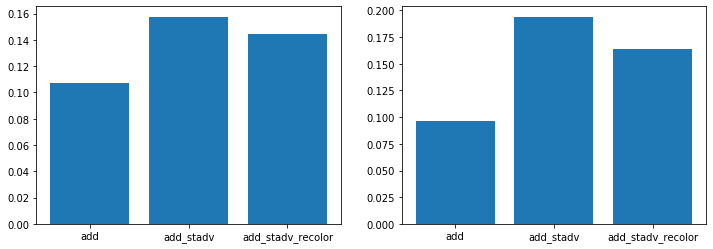

In [23]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].bar(["add", "add_stadv", "add_stadv_recolor"], [np.mean(cosd_to_target_map["add"]["gradient"]),
                                                     np.mean(cosd_to_target_map["add_stadv"]["gradient"]),
                                                     np.mean(cosd_to_target_map["add_stadv_recolor"]["gradient"])])

ax[1].bar(["add", "add_stadv", "add_stadv_recolor"], [np.mean(lpips_to_original_image["add"]["gradient"]),
                                                     np.mean(lpips_to_original_image["add_stadv"]["gradient"]),
                                                     np.mean(lpips_to_original_image["add_stadv_recolor"]["gradient"])])

In [70]:
np.random.seed(73)
torch.manual_seed(73)
torch.cuda.manual_seed(73)

In [71]:
trasform_imagenet = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor()])

imagenet_val = torchvision.datasets.ImageNet(root="./data/", split="val", transform=trasform_imagenet)

test_loader = torch.utils.data.DataLoader(
        imagenet_val,
        batch_size=1024,
        shuffle=True
    )

In [72]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

In [73]:
a = np.random.randint(1024, size=16)
x = normalizer.forward(images[a]).to(device)
print(labels[a])

tensor([774, 427, 627, 367, 404, 162,  88, 228, 147,  74, 612, 221, 647, 471,
        240, 374])


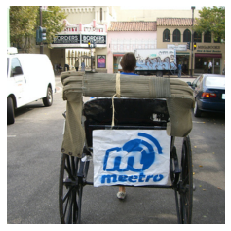

In [74]:

plt.imshow(torch_to_image(x[10:11], data_mean, data_std))
plt.axis('off');

In [85]:
### cosd to original map
img_advs = {"add": {"gradient":[], "smooth_grad": [], "uniform_grad": [], "softplus": []}, 
         "add_stadv": {"gradient":[], "smooth_grad": [], "uniform_grad": [], "softplus": []},
         "add_stadv_recolor": {"gradient":[], "smooth_grad": [], "uniform_grad": [], "softplus": []}}

for att in ["add", "add_stadv", "add_stadv_recolor"]:
    for method in ["gradient", "smooth_grad", "uniform_grad", "softplus"]:
        if method == "gradient" or method == "softplus":
            for folder in os.listdir("../examples/post_hoc_results_batch/"+att+"/"+method+"/"):
                path = "../examples/post_hoc_results_batch/"+att+"/"+method+"/"+folder+"/"
                for file in os.listdir(path):
                    if file.startswith("x_"):
                        img_advs[att][method].append(torch.load(path+file))
        
        elif method == "smooth_grad" or method == "uniform_grad":
            for batch_folder in os.listdir("../examples/post_hoc_results_batch/"+att+"/"+method+"/"):
                temp = []
                for folder in os.listdir("../examples/post_hoc_results_batch/"+att+"/"+method+"/"+batch_folder+"/"):
                    path = "../examples/post_hoc_results_batch/"+att+"/"+method+"/"+batch_folder+"/"+folder+"/"
                    for file in os.listdir(path):
                        if file.startswith("x_"):
                            temp.append(torch.load(path+file))
                img_advs[att][method].append(torch.cat(temp, dim=0))

In [89]:
img_advs["add"]['uniform_grad'][0].size()

torch.Size([16, 3, 224, 224])

In [76]:
a = torch.tensor([1,2,4])
b = torch.tensor([2,3,4])
torch.stack([a,b], dim=0).size()

torch.Size([2, 3])

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


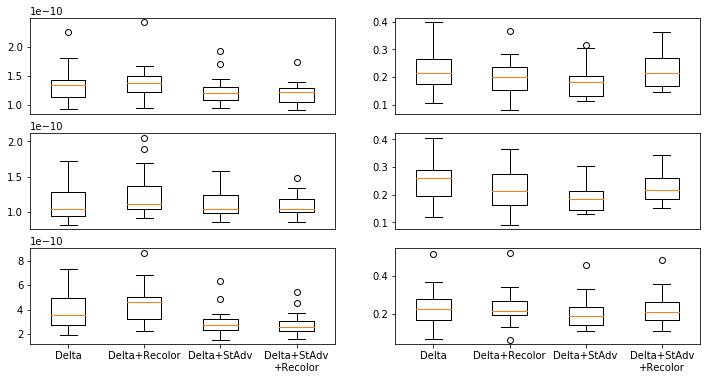

In [32]:
fig, ax = plt.subplots(3,2, figsize=(12, 6))
attacks = ["add", "add_recolor", "add_stadv", "add_stadv_recolor"]
for i, method in enumerate(["smooth_grad", "uniform_grad", "softplus"]):
    ax[i, 0].boxplot([mse_to_target_map[k][method] for k in attacks])
    ax[i, 1].boxplot([lpips_to_original_image[k][method] for k in attacks])
    ax[i, 0].set_xticks([])
    ax[i, 1].set_xticks([])
ax[2, 0].set_xticks([1,2,3,4])
ax[2, 0].set_xticklabels(["Delta", "Delta+Recolor", "Delta+StAdv", "Delta+StAdv\n+Recolor"], rotation=0)
ax[2, 1].set_xticks([1,2,3,4])
ax[2, 1].set_xticklabels(["Delta", "Delta+Recolor", "Delta+StAdv", "Delta+StAdv\n+Recolor"], rotation=0);

### rank correlation and cosine distance

In [5]:
from scipy.stats import spearmanr as spr
import scipy.spatial as spatial

In [6]:
# laod models
model = torchvision.models.vgg16(pretrained=True)
# softplus
softplus_model = convert_relu_to_softplus(model, beta=0.8)
softplus_model = softplus_model.eval().to(device)
# we need to substitute the ReLus with softplus to avoid zero second derivative
model = torchvision.models.vgg16(pretrained=True)
model = convert_relu_to_softplus(model, beta=100)
####
model = model.eval().to(device)


In [7]:
np.random.seed(72)
torch.manual_seed(72)
torch.cuda.manual_seed(72)
trasform_imagenet = torchvision.transforms.Compose([torchvision.transforms.Resize(256),
                                        torchvision.transforms.CenterCrop(224),
                                        torchvision.transforms.ToTensor()])

imagenet_val = torchvision.datasets.ImageNet(root="./data/", split="val", transform=trasform_imagenet)

test_loader = torch.utils.data.DataLoader(
        imagenet_val,
        batch_size=1024,
        shuffle=True
    )
#### load images #####
dataiter = iter(test_loader)
images_batch, labels_batch = next(dataiter)
#### target ######
images_batch, labels_batch = next(dataiter)

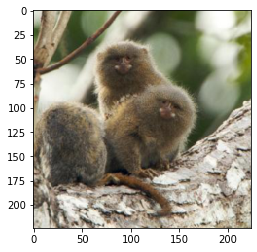

In [8]:
plt.imshow(torch_to_image(images_batch[80].unsqueeze(0), np.zeros((1,3)), np.ones((1,3))))

In [9]:
normalizer = mister_ed_utils.DifferentiableNormalize(mean=np.array([0,0,0]),
                                               std=np.array([1,1,1]))

In [10]:
spr_to_target_map = {"add": {"smooth_grad": [], "uniform_grad": [], "softplus": []}, 
         "add_stadv": {"smooth_grad": [], "uniform_grad": [], "softplus": []},
         "add_recolor": {"smooth_grad": [], "uniform_grad": [], "softplus": []},
         "add_stadv_recolor": {"smooth_grad": [], "uniform_grad": [], "softplus": []}}

for att in ["add", "add_recolor", "add_stadv", "add_stadv_recolor"]:
    for method in ["smooth_grad", "uniform_grad", "softplus"]:
        for folder in os.listdir("../post-hoc_results_old/"+att+"/"+method+"/"):
            for file in os.listdir("../post-hoc_results_old/"+att+"/"+method+"/"+folder):
                if file.startswith("x_"):
                    p_img = torch.load("../post-hoc_results_old/"+att+"/"+method+"/"+folder+"/"+file)
            img = images_batch[int(folder.split("_")[-2])].unsqueeze(0).cuda()
            idx = model(normalizer.forward(img)).argmax()
            sigma = (torch.max(normalizer.forward(img)) - torch.min(normalizer.forward(img))).item() / 5
            target_img = images_batch[int(folder.split("_")[-1])].unsqueeze(0).cuda()
            if method == "smooth_grad":
                adv_expl = get_expl(model, normalizer.forward(p_img), "saliency", desired_index=idx, smooth=True, sigma=sigma)
                target_expl = get_expl(model, normalizer.forward(target_img), "saliency", desired_index=idx, smooth=True, sigma=sigma)
            elif method == "softplus":
                adv_expl = get_expl(softplus_model, normalizer.forward(p_img), "saliency", desired_index=idx)
                target_expl = get_expl(softplus_model, normalizer.forward(target_img), "saliency", desired_index=idx)
            else:
                adv_expl = get_expl(model, normalizer.forward(p_img), method, desired_index=idx, sigma=sigma)
                target_expl = get_expl(model, normalizer.forward(target_img), method, desired_index=idx, sigma=sigma)
            spr_to_target_map[att][method].append(spatial.distance.cosine(adv_expl.detach().cpu().flatten(),
                                                     target_expl.detach().cpu().flatten()))

/home/ubuntu/captum/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


### LPIPS

In [11]:
lpips_to_original_image = {"add": {"smooth_grad": [], "uniform_grad": [], "softplus": []}, 
         "add_stadv": {"smooth_grad": [], "uniform_grad": [], "softplus": []},
         "add_recolor": {"smooth_grad": [], "uniform_grad": [], "softplus": []},
         "add_stadv_recolor": {"smooth_grad": [], "uniform_grad": [], "softplus": []}}

for att in ["add", "add_recolor", "add_stadv", "add_stadv_recolor"]:
    for method in ["smooth_grad", "uniform_grad", "softplus"]:
        for folder in os.listdir("../post-hoc_results_old/"+att+"/"+method+"/"):
            with open("../post-hoc_results_old/"+att+"/"+method+"/"+folder+"/output.log", "r") as f:
                lines = f.readlines()
                if lines[-1].startswith("LPIPS"):
                    lpips_to_original_image[att][method].append(float(lines[-1].strip().split(" ")[-1]))
                        

### viz

In [12]:
errors = {}
for k, v in spr_to_target_map.items():
    errors[k] = {k1: np.std(v1) for k1,v1 in v.items()}

In [13]:
lpips_errors = {}
for k, v in lpips_to_original_image.items():
    lpips_errors[k] = {k1: np.std(v1) for k1,v1 in v.items()}

Text(0, 0.5, '$LPIPS(x_{adv}, x)$')

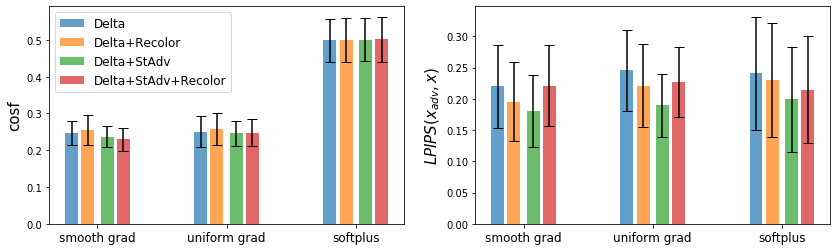

In [14]:
fig, ax = plt.subplots(1,2, figsize=(14, 4))

x_s = np.array([1,2,3])
ax[0].bar(x_s - 0.2, 
           [np.mean(spr_to_target_map["add"]["smooth_grad"]), 
            np.mean(spr_to_target_map["add"]["uniform_grad"]),
            np.mean(spr_to_target_map["add"]["softplus"])], 
            yerr=[errors["add"]["smooth_grad"], errors["add"]["uniform_grad"], 
                  errors["add"]["softplus"]], width=0.1, label="Delta",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[0].bar(x_s - 0.075, 
           [np.mean(spr_to_target_map["add_recolor"]["smooth_grad"]),
            np.mean(spr_to_target_map["add_recolor"]["uniform_grad"]),
            np.mean(spr_to_target_map["add_recolor"]["softplus"])], 
            yerr=[errors["add_recolor"]["smooth_grad"], errors["add_recolor"]["uniform_grad"],
                  errors["add_recolor"]["softplus"]], width=0.1, label="Delta+Recolor", 
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[0].bar(x_s + 0.075, 
           [np.mean(spr_to_target_map["add_stadv"]["smooth_grad"]),
            np.mean(spr_to_target_map["add_stadv"]["uniform_grad"]),
            np.mean(spr_to_target_map["add_stadv"]["softplus"])], 
            yerr=[errors["add_stadv"]["smooth_grad"], errors["add_stadv"]["uniform_grad"],
                  errors["add_stadv"]["softplus"]], width=0.1, label="Delta+StAdv",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[0].bar(x_s + 0.2, 
           [np.mean(spr_to_target_map["add_stadv_recolor"]["smooth_grad"]),
            np.mean(spr_to_target_map["add_stadv_recolor"]["uniform_grad"]),
            np.mean(spr_to_target_map["add_stadv_recolor"]["softplus"])], 
            yerr=[errors["add_stadv_recolor"]["smooth_grad"], errors["add_stadv_recolor"]["uniform_grad"],
                  errors["add_stadv_recolor"]["softplus"]], width=0.1, label="Delta+StAdv+Recolor",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[0].set_xticks(x_s)
ax[0].set_xticklabels(["smooth grad", "uniform grad", "softplus"], fontsize=12)
ax[0].legend(fontsize=12)
ax[0].set_ylabel("cosf", fontsize=15)
# ax[0].ticklabel_format(style='sci', axis='y',scilimits=(0,0), useMathText=True)
ax[0].yaxis.get_offset_text().set_fontsize(14)
# ax[0].set_ylim(top=7e-10)

ax[1].bar(x_s - 0.2, 
           [np.mean(lpips_to_original_image["add"]["smooth_grad"]), 
            np.mean(lpips_to_original_image["add"]["uniform_grad"]),
            np.mean(lpips_to_original_image["add"]["softplus"])], 
            yerr=[lpips_errors["add"]["smooth_grad"], lpips_errors["add"]["uniform_grad"],
                  lpips_errors["add"]["softplus"]], width=0.1, label="add",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[1].bar(x_s - 0.075, 
           [np.mean(lpips_to_original_image["add_recolor"]["smooth_grad"]),
            np.mean(lpips_to_original_image["add_recolor"]["uniform_grad"]),
            np.mean(lpips_to_original_image["add_recolor"]["softplus"])],
            yerr=[lpips_errors["add_recolor"]["smooth_grad"], lpips_errors["add_recolor"]["uniform_grad"],
                  lpips_errors["add_recolor"]["softplus"]], width=0.1, label="add_recolor",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[1].bar(x_s + 0.075, 
           [np.mean(lpips_to_original_image["add_stadv"]["smooth_grad"]),
            np.mean(lpips_to_original_image["add_stadv"]["uniform_grad"]),
            np.mean(lpips_to_original_image["add_stadv"]["softplus"])],
            yerr=[lpips_errors["add_stadv"]["smooth_grad"], lpips_errors["add_stadv"]["uniform_grad"],
                  lpips_errors["add_stadv"]["softplus"]], width=0.1, label="add_stadv",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[1].bar(x_s + 0.2, 
           [np.mean(lpips_to_original_image["add_stadv_recolor"]["smooth_grad"]),
            np.mean(lpips_to_original_image["add_stadv_recolor"]["uniform_grad"]),
            np.mean(lpips_to_original_image["add_stadv_recolor"]["softplus"])],
            yerr=[lpips_errors["add_stadv_recolor"]["smooth_grad"], lpips_errors["add_stadv_recolor"]["uniform_grad"],
                  lpips_errors["add_stadv_recolor"]["softplus"]], width=0.1, label="add_stadv_recolor",
            align='center', alpha=0.7, ecolor='black', capsize=5)

ax[1].set_xticks(x_s)
ax[1].set_xticklabels(["smooth grad", "uniform grad", "softplus"], fontsize=12)
# ax[1].legend(fontsize=12)
# ax[1].set_ylim(bottom=0.25)
ax[1].set_ylabel(r"$LPIPS(x_{adv}, x)$", fontsize=15)
# plt.savefig("compare_attacks_mse.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

In [15]:
spr_to_target_map["add"]["softplus"]

[0.544447124004364,
 0.4543105959892273,
 0.4945991635322571,
 0.5388741195201874,
 0.48854362964630127,
 0.4680904150009155,
 0.47968101501464844,
 0.4682984948158264,
 0.7029964327812195,
 0.4564272165298462,
 0.4846741557121277,
 0.4946942925453186,
 0.4536858797073364,
 0.46861064434051514,
 0.6253004670143127,
 0.4848872423171997,
 0.5522667765617371,
 0.4307059645652771,
 0.4711607098579407,
 0.5355996489524841,
 0.4880191683769226,
 0.4339118003845215,
 0.5199194848537445,
 0.4627271294593811,
 0.45863115787506104]

In [17]:
spr_to_target_map["add_stadv"]["softplus"]

[0.5477940142154694,
 0.4580618739128113,
 0.488447904586792,
 0.5385925769805908,
 0.4986790418624878,
 0.4683356285095215,
 0.4803920388221741,
 0.46581852436065674,
 0.7115625739097595,
 0.4616820216178894,
 0.48784029483795166,
 0.4909508228302002,
 0.4527932405471802,
 0.4665847420692444,
 0.6066022515296936,
 0.4839322566986084,
 0.5656663775444031,
 0.4320473074913025,
 0.5022010803222656,
 0.5331394672393799,
 0.4910474419593811,
 0.4241443872451782,
 0.5160622298717499,
 0.47740423679351807,
 0.4673451781272888]